# CEO-Request Challenge

## 1. Summary of Problem Statement

❓ **How could Olist improve its profit** ❓

### P&L Rules

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL by month** per seller

#### Costs
**Reputation costs** *estimated* per order with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that has ever join the platform, as well as the square root of the total cumulated number of items that were ever sold.  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both number of sellers to manage and sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that Olist has a lower IT Cost with few sellers selling a lot of items rather than the opposite  
- with **1000 sellers** and a total of **100 items** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 items** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

# Start
At the start we are going to focus on building a good relational model of tables that are actually useful for the task at hand

In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Orders table

In [106]:
customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
product_category = pd.read_csv('product_category_name_translation.csv')

In [107]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [108]:
def get_wait_time(df = orders):
    # handle datetime
    df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
    df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
    df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
    
    # Compute just the number of days in each time_delta
    import datetime
    one_day_delta = datetime.timedelta(days=1) # a "timedelta" object of 1 day
    one_day_delta = np.timedelta64(24, 'h') # a "timedelta64" object of 1 day (use the one you prefer)

    # Assign compute delay vs expected
    df.loc[:,'wait_time'] = \
        (df['order_delivered_customer_date'] - df['order_purchase_timestamp']) / one_day_delta

    df.loc[:,'delay_vs_expected'] = \
        (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']) / one_day_delta

    df.loc[:,'expected_wait_time'] = \
        (df['order_estimated_delivery_date'] - df['order_purchase_timestamp']) / one_day_delta

    df.loc[:,'delay_vs_expected'] = df['delay_vs_expected'].clip(0)

    return df[['order_id', 'wait_time', 'expected_wait_time', 'delay_vs_expected', 'order_status']]

In [109]:
ord = get_wait_time()
ord.head()

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0,delivered
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0,delivered


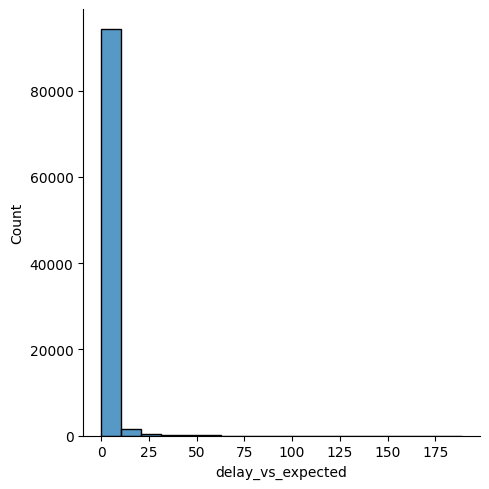

In [110]:
sns.displot(ord['delay_vs_expected'])

In [111]:
def get_review_score(df = reviews):
    dim_is_one_star = lambda x: int(x==1)
    dim_is_five_star = lambda x: int(x==5)

    df["dim_is_five_star"] = df["review_score"].map(dim_is_five_star) # --> Series([0, 1, 1, 0, 0, 1 ...])
    df["dim_is_one_star"] = df["review_score"].map(dim_is_one_star) # --> Series([0, 1, 1, 0, 0, 1 ...])
    return df[["order_id", "dim_is_five_star", "dim_is_one_star", "review_score"]]

In [112]:
rev = get_review_score()
rev.head()

,order_id,dim_is_five_star,dim_is_one_star,review_score
0,73fc7af87114b39712e6da79b0a377eb,0,0,4
1,a548910a1c6147796b98fdf73dbeba33,1,0,5
2,f9e4b658b201a9f2ecdecbb34bed034b,1,0,5
3,658677c97b385a9be170737859d3511b,1,0,5
4,8e6bfb81e283fa7e4f11123a3fb894f1,1,0,5


In [113]:
def get_number_products(df = order_items):
    # change name of column order_item_id to number_of_products
    return df[["order_id", "order_item_id"]].groupby("order_id").count().reset_index().rename(columns = {"order_item_id": "number_of_products"})


In [114]:
get_number_products().head()

,order_id,number_of_products
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1
2,000229ec398224ef6ca0657da4fc703e,1
3,00024acbcdf0a6daa1e931b038114c75,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1


In [115]:
def get_number_items(df = order_items):
    return df.groupby("order_id").count()\
        .rename(columns={"order_item_id": "number_of_items"})\
        .sort_values("number_of_items")[['number_of_items']]

In [116]:
da = get_number_items()
da.head()

,number_of_items
order_id,
00010242fe8c5a6d1ba2dd792cb16214,1
000c3e6612759851cc3cbb4b83257986,1
000e562887b1f2006d75e0be9558292e,1
000e63d38ae8c00bbcb5a30573b99628,1
000e906b789b55f64edcb1f84030f90d,1


In [117]:
def get_number_sellers(order_items = order_items):
    sell = \
    order_items.groupby('order_id')['seller_id'].nunique().reset_index()

    sell.columns = ['order_id', 'number_of_sellers']
    sell.sort_values('number_of_sellers')
    return sell

In [118]:
get_number_sellers().head()

,order_id,number_of_sellers
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1
2,000229ec398224ef6ca0657da4fc703e,1
3,00024acbcdf0a6daa1e931b038114c75,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1


In [119]:
def get_price_and_freight(order_items = order_items):
    return order_items.groupby('order_id',
             as_index=False).agg({'price': 'sum',
                                  'freight_value': 'sum'})

In [120]:
get_price_and_freight().head()

,order_id,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14


In [121]:
def get_distance_seller_customer(orders = orders, order_items = order_items, sellers = sellers, customers = customers, geo = geolocation):
    """
    Returns a DataFrame with:
    order_id, distance_seller_customer
    """
    def haversine_distance(lon1, lat1, lon2, lat2):
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        km = 6367 * c
        return km
    geo = geo.groupby('geolocation_zip_code_prefix',
                        as_index=False).first()

    # Merge geo_location for sellers
    sellers_mask_columns = [
        'seller_id', 'seller_zip_code_prefix', 'geolocation_lat', 'geolocation_lng'
    ]

    sellers_geo = sellers.merge(
        geo,
        how='left',
        left_on='seller_zip_code_prefix',
        right_on='geolocation_zip_code_prefix')[sellers_mask_columns]

    # Merge geo_location for customers
    customers_mask_columns = ['customer_id', 'customer_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']

    customers_geo = customers.merge(
        geo,
        how='left',
        left_on='customer_zip_code_prefix',
        right_on='geolocation_zip_code_prefix')[customers_mask_columns]

    # Match customers with sellers in one table
    customers_sellers = customers.merge(orders, on='customer_id')\
        .merge(order_items, on='order_id')\
        .merge(sellers, on='seller_id')\
        [['order_id', 'customer_id','customer_zip_code_prefix', 'seller_id', 'seller_zip_code_prefix']]

    # Add the geoloc
    matching_geo = customers_sellers.merge(sellers_geo,
                                        on='seller_id')\
        .merge(customers_geo,
                on='customer_id',
                suffixes=('_seller',
                            '_customer'))
    # Remove na()
    matching_geo = matching_geo.dropna()

    matching_geo.loc[:, 'distance_seller_customer'] =\
        matching_geo.apply(lambda row:
                            haversine_distance(row['geolocation_lng_seller'],
                                                row['geolocation_lat_seller'],
                                                row['geolocation_lng_customer'],
                                                row['geolocation_lat_customer']),
                            axis=1)
    # Since an order can have multiple sellers,
    # return the average of the distance per order
    order_distance =\
        matching_geo.groupby('order_id',
                                as_index=False).agg({'distance_seller_customer':
                                                    'mean'})

    return order_distance

In [122]:
def get_training_data():
    df1=get_wait_time()
    df2=get_review_score()
    df3=get_number_products()
    df4=get_number_sellers()
    df5=get_price_and_freight()
    df6=get_distance_seller_customer()
    df=(df1.merge(df3,on="order_id", how="inner")
        .merge(df4,on="order_id", how="inner")
        .merge(df5,on="order_id", how="inner")
        .merge(df2,on="order_id", how="inner")
        .merge(df6,on="order_id", how="inner").dropna())
    return df

In [123]:
get_training_data().head()

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,number_of_products,number_of_sellers,price,freight_value,dim_is_five_star,dim_is_one_star,review_score,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,1,1,29.99,8.72,0,0,4,18.052495
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,1,1,118.70,22.76,0,0,4,855.754961
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered,1,1,159.90,19.22,1,0,5,513.807539
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0,delivered,1,1,45.00,27.20,1,0,5,1821.655930
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0,delivered,1,1,19.90,8.72,1,0,5,30.155092


## Simple orders analysis

In [124]:
order = get_training_data()

In [125]:
order.shape

(95878, 13)

### 1. Inspect features

In [126]:
order.describe()


,wait_time,expected_wait_time,delay_vs_expected,number_of_products,number_of_sellers,price,freight_value,dim_is_five_star,dim_is_one_star,review_score,distance_seller_customer
count,95878.000000,95878.000000,95878.000000,95878.000000,95878.000000,95878.000000,95878.000000,95878.000000,95878.000000,95878.000000,95878.000000
mean,12.513933,23.740547,0.753436,1.141784,1.013914,136.691061,22.749590,0.592086,0.097687,4.155375,600.279650
std,9.455256,8.768944,4.656610,0.535839,0.123631,207.667490,21.516493,0.491450,0.296892,1.285243,594.433593
min,0.533414,2.008009,0.000000,1.000000,1.000000,0.850000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,6.755046,18.327040,0.000000,1.000000,1.000000,45.900000,13.820000,0.000000,0.000000,4.000000,187.074607
50%,10.203791,23.230758,0.000000,1.000000,1.000000,85.990000,17.160000,1.000000,0.000000,5.000000,433.663905
75%,15.660385,28.415353,0.000000,1.000000,1.000000,149.900000,23.990000,1.000000,0.000000,5.000000,796.993519
max,208.351759,155.135463,188.975081,21.000000,5.000000,13440.000000,1794.960000,1.000000,1.000000,5.000000,8731.462170


In [127]:
order.info()


<class 'pandas.core.frame.DataFrame'>
Index: 95878 entries, 0 to 97971
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  95878 non-null  object 
 1   wait_time                 95878 non-null  float64
 2   expected_wait_time        95878 non-null  float64
 3   delay_vs_expected         95878 non-null  float64
 4   order_status              95878 non-null  object 
 5   number_of_products        95878 non-null  int64  
 6   number_of_sellers         95878 non-null  int64  
 7   price                     95878 non-null  float64
 8   freight_value             95878 non-null  float64
 9   dim_is_five_star          95878 non-null  int64  
 10  dim_is_one_star           95878 non-null  int64  
 11  review_score              95878 non-null  int64  
 12  distance_seller_customer  95878 non-null  float64
dtypes: float64(6), int64(5), object(2)
memory usage: 10.2+ MB


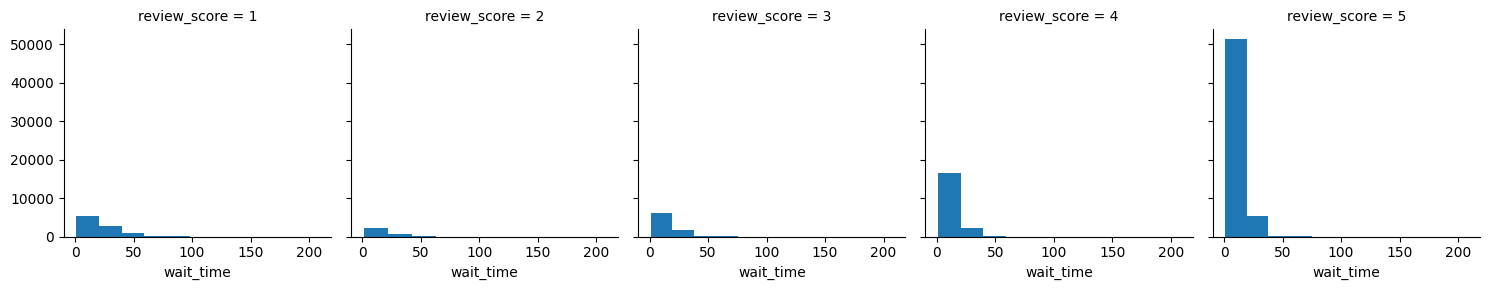

In [128]:
g = sns.FacetGrid(data=order, col="review_score")
g.map(plt.hist, "wait_time")


<Axes: xlabel='price', ylabel='Density'>

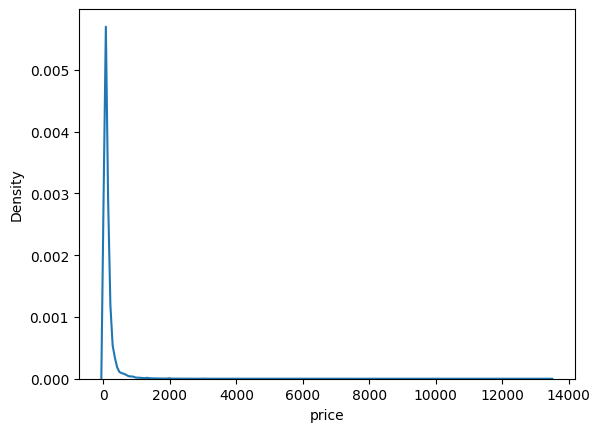

In [129]:
sns.kdeplot(order['price'])


<Axes: xlabel='freight_value', ylabel='Density'>

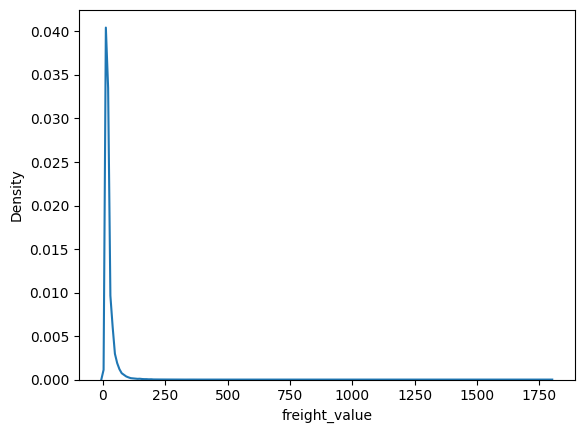

In [130]:
sns.kdeplot(order['freight_value'])


<Axes: xlabel='distance_seller_customer', ylabel='Density'>

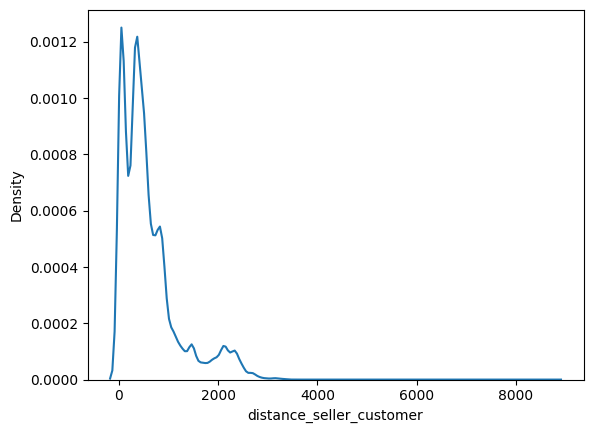

In [131]:
sns.kdeplot(order['distance_seller_customer'])


In [132]:
order.iloc[:,1:]

,wait_time,expected_wait_time,delay_vs_expected,order_status,number_of_products,number_of_sellers,price,freight_value,dim_is_five_star,dim_is_one_star,review_score,distance_seller_customer
0,8.436574,15.544063,0.0,delivered,1,1,29.99,8.72,0,0,4,18.052495
1,13.782037,19.137766,0.0,delivered,1,1,118.70,22.76,0,0,4,855.754961
2,9.394213,26.639711,0.0,delivered,1,1,159.90,19.22,1,0,5,513.807539
3,13.208750,26.188819,0.0,delivered,1,1,45.00,27.20,1,0,5,1821.655930
4,2.873877,12.112049,0.0,delivered,1,1,19.90,8.72,1,0,5,30.155092
...,...,...,...,...,...,...,...,...,...,...,...,...
97967,8.218009,18.587442,0.0,delivered,1,1,72.00,13.08,1,0,5,69.437414
97968,22.193727,23.459051,0.0,delivered,1,1,174.90,20.10,0,0,4,473.800585
97969,24.859421,30.384225,0.0,delivered,1,1,205.99,65.02,1,0,5,967.443406
97970,17.086424,37.105243,0.0,delivered,2,1,359.98,81.18,0,0,2,369.914458


<Axes: >

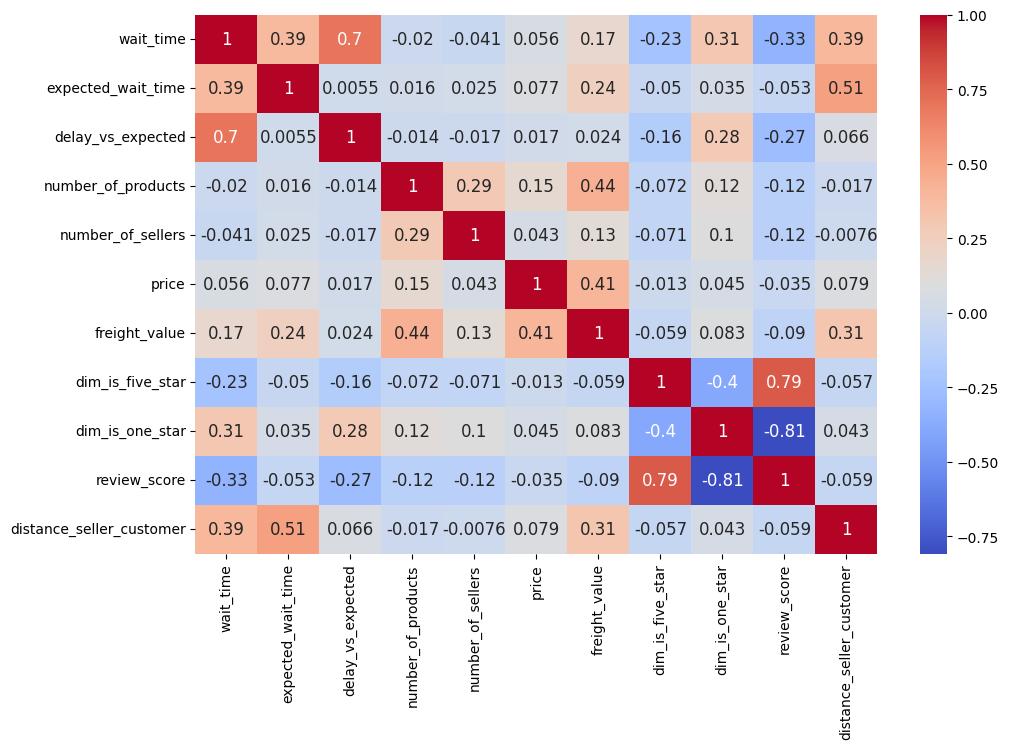

In [133]:
# Correlation plot
plt.figure(figsize=(11,7))
sns.heatmap(order.select_dtypes(exclude = ["object"]).corr(), cmap='coolwarm', annot = True, annot_kws={"size": 12})


## 2 - Simple regression of review_score against delivery duration

it seems that `review_score` is mostly correlated with `wait_time` (= - 34%) and `delay_vs_expected` (- 27%).

(0.0, 6.082754270654327)

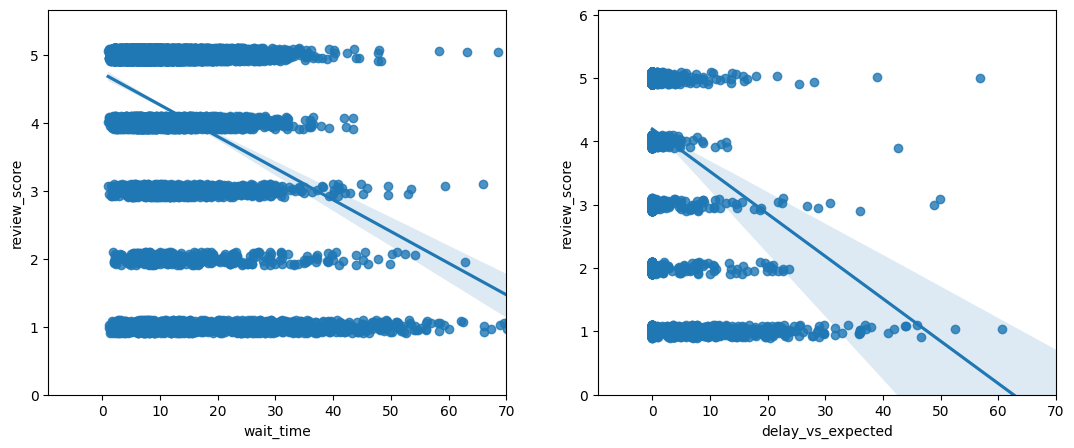

In [134]:
sample = order.sample(10000, random_state=42)
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.regplot(x = sample.wait_time, y= sample.review_score, y_jitter=.1)
plt.xlim(right=70)
plt.ylim(bottom=0)

plt.subplot(1,2,2)
sns.regplot(x = sample.delay_vs_expected, y= sample.review_score, y_jitter=.1)
plt.xlim(right=70)
plt.ylim(bottom=0)


As expected the delay seems more impactful than the waiting time

We have to be sure that the coefficient and results are statistically significant, for that we analyze the confidence interval that seaborn provides

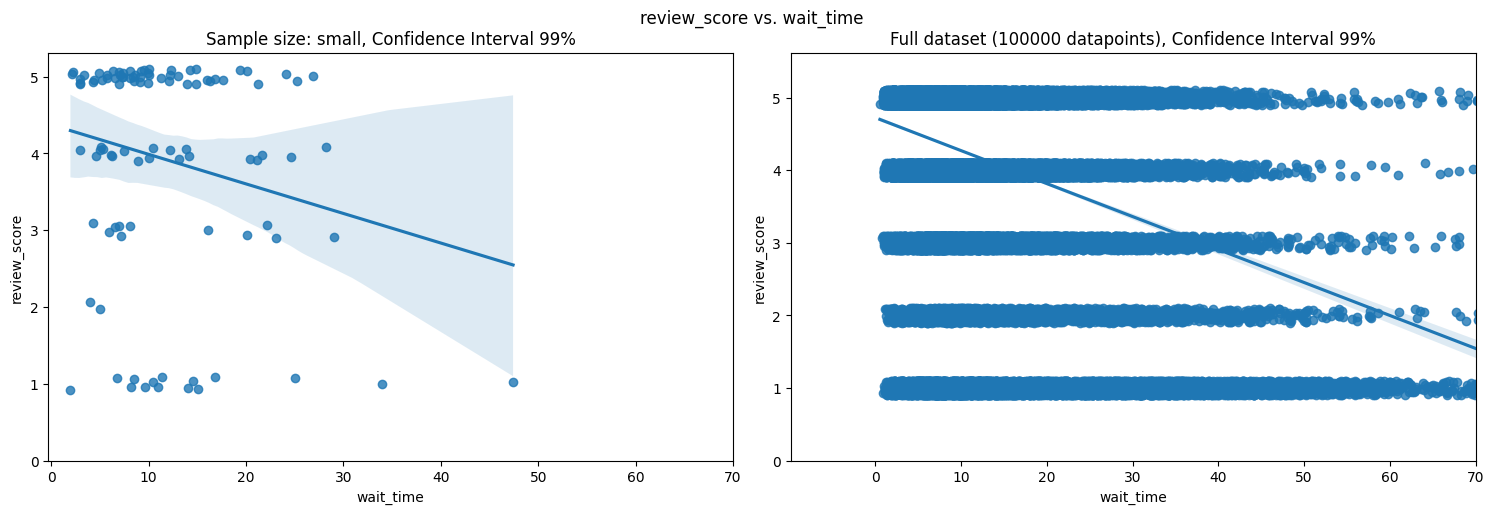

In [135]:
sample = order.sample(100, random_state=42)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle('review_score vs. wait_time')
fig.tight_layout()

sns.regplot(x = sample.wait_time, y= sample.review_score, y_jitter=.1, ci=99, ax = axes[0])
axes[0].set_xlim(right=70)
axes[0].set_ylim(bottom=0)
axes[0].set_title("Sample size: small, Confidence Interval 99%")


sns.regplot(x = order.wait_time, y= order.review_score, y_jitter=.1, ci=99, ax = axes[1])
axes[1].set_xlim(right=70)
axes[1].set_ylim(bottom=0)
axes[1].set_title("Full dataset (100000 datapoints), Confidence Interval 99%")

plt.show();


Interpretation:

* Null Hypothesis $H_0$ : "this variable does not influence the review score", a.k.a its coefficient is equal to zero

When plotting all our datapoints:
- The 95% confidence interval for the slope does not contain the value 0.
    -  We are `95% confident that slower deliveries are associated with weaker reviews`.
- The **`p-value`** associated with the null hypothesis "the impact of delivery time on review scores is almost zero" is lower than 5%
    -  We can safely reject this null hypothesis and consider the **`alternative hypothesis`** = `"the delivery time has an impact on the review score"` 

Our findings are said to be **statistically significant**. 

However, **correlation does NOT imply causality**. 

- It can be inherently slower to deliver certain products (e.g.heavy products)
    - These categories of products will often have a low review_score, not matter how long their delivery time is. 

Identifying **confounding factor** is crucial and cannot be done with a simple univariate regression. 

## 3. Multivariate regression of review_score

### 3.1 Development

We have tried with these 2 variables first because at first glance they seem to be the most important, but later we will examine with more variables

In [136]:
import statsmodels.formula.api as smf

model3 = smf.ols('review_score ~ wait_time + delay_vs_expected', data=order).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     6193.
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        17:27:02   Log-Likelihood:            -1.5428e+05
No. Observations:               95878   AIC:                         3.086e+05
Df Residuals:                   95875   BIC:                         3.086e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.6503      0.00

In [137]:
features = [
    "wait_time",
    "delay_vs_expected",
    "number_of_products",
    "number_of_sellers",
    "price",
    "freight_value",
    "distance_seller_customer",
]

In [138]:
orders_standardized = order.copy()
for f in features:
    mu = order[f].mean()
    sigma = order[f].std()
    orders_standardized[f] = order[f].map(lambda x: (x - mu) / sigma)
orders_standardized

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,number_of_products,number_of_sellers,price,freight_value,dim_is_five_star,dim_is_one_star,review_score,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,-0.431227,15.544063,-0.161799,delivered,-0.264602,-0.112541,-0.513807,-0.652039,0,0,4,-0.979465
1,53cdb2fc8bc7dce0b6741e2150273451,0.134116,19.137766,-0.161799,delivered,-0.264602,-0.112541,-0.086634,0.000484,0,0,4,0.429779
2,47770eb9100c2d0c44946d9cf07ec65d,-0.329946,26.639711,-0.161799,delivered,-0.264602,-0.112541,0.111760,-0.164041,1,0,5,-0.145470
3,949d5b44dbf5de918fe9c16f97b45f8a,0.073485,26.188819,-0.161799,delivered,-0.264602,-0.112541,-0.441528,0.206837,1,0,5,2.054689
4,ad21c59c0840e6cb83a9ceb5573f8159,-1.019545,12.112049,-0.161799,delivered,-0.264602,-0.112541,-0.562395,-0.652039,1,0,5,-0.959106
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97967,9c5dedf39a927c1b2549525ed64a053c,-0.454342,18.587442,-0.161799,delivered,-0.264602,-0.112541,-0.311513,-0.449404,1,0,5,-0.893022
97968,63943bddc261676b46f01ca7ac2f7bd8,1.023747,23.459051,-0.161799,delivered,-0.264602,-0.112541,0.183991,-0.123142,0,0,4,-0.212772
97969,83c1379a015df1e13d02aae0204711ab,1.305675,30.384225,-0.161799,delivered,-0.264602,-0.112541,0.333701,1.964559,1,0,5,0.617670
97970,11c177c8e97725db2631073c19f07b62,0.483593,37.105243,-0.161799,delivered,1.601628,-0.112541,1.075223,2.715610,0,0,2,-0.387537


In [139]:
formula = "review_score ~ " + ' + '.join(features)
model4 = smf.ols(formula = formula, data = orders_standardized).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     2322.
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        17:27:02   Log-Likelihood:            -1.5260e+05
No. Observations:               95878   AIC:                         3.052e+05
Df Residuals:                   95870   BIC:                         3.053e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

What are the most important variables in this model?

<Axes: >

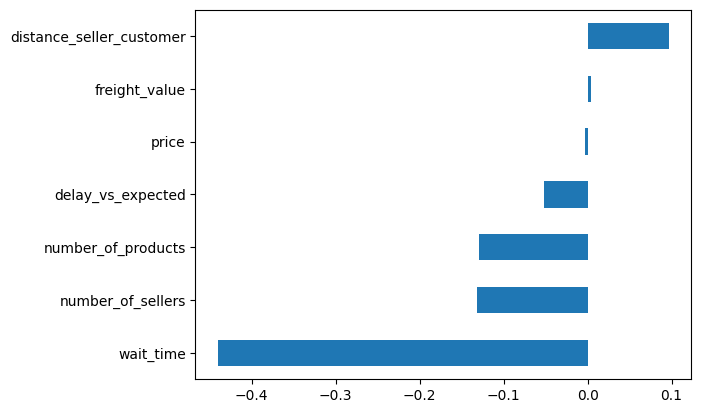

In [140]:
model4.params[1:].sort_values().plot(kind='barh')

 

- `wait_time` is the biggest explanatory variable
- The more `items` and `sellers` there are for a single order, the lower the `review_score` seems to be
- Distance also plays a role in customers' satisfaction.
- Depending on your choice of feature, you may not be able to conclude anything about `price` and `freight_value` if their p-values are too high
    
- Overall, this multivariate regression remains statistically significant, because its F-statistics are much greater than 1 (at least one feature has a very low p-value)

- R-squared hasn't increased by much. Most of the explainability of `review_score` lies outside of the orders dataset.

### 3.2 Evaluation of model performance

In [141]:
predicted_review_score = model4.predict(orders_standardized[features])
residuals = predicted_review_score - orders_standardized.review_score

In [142]:
rmse = (residuals**2).mean()**0.5
rmse

np.float64(1.188420097934931)

Text(0.5, 1.0, 'residuals density plot')

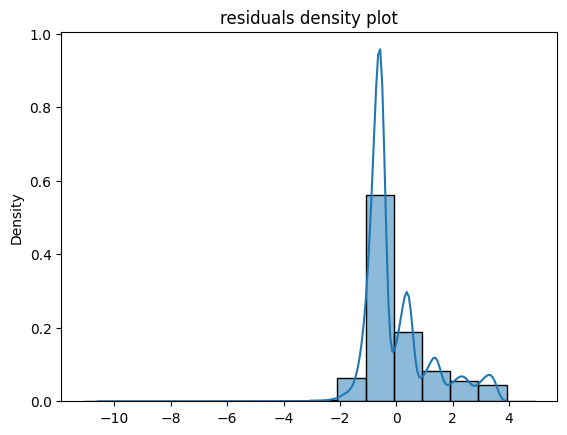

In [143]:
sns.histplot(residuals, kde=True, stat='density', discrete=True)
plt.title('residuals density plot')

Text(0.5, 1.0, 'distribution of predicted and actual values')

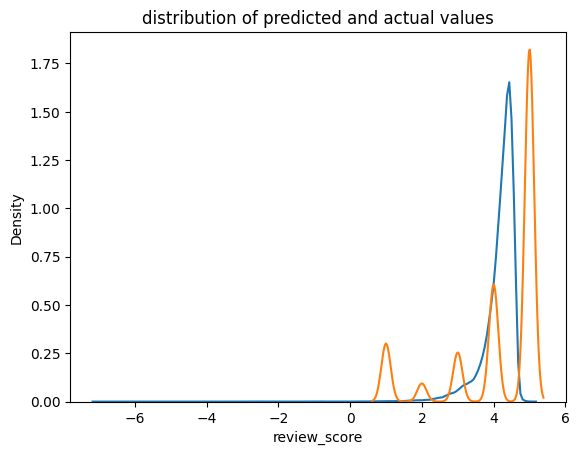

In [144]:
sns.kdeplot(predicted_review_score, label='predicted review score')
sns.kdeplot(order.review_score, label = 'actual review score')
plt.title('distribution of predicted and actual values')

It seems it is hard to regress the `review_score` of an order vs. its `wait_time`. because the `review_score` is a discrete number that could also be interpreted as a category: 1 (very bad), 2 (bad), 3 (average), 4 (good), 5 (excellent).

So in the end, our model is not so great, for two reasons:
- First, because we don't have enough features to explain a significant proportion of the review_scores (low R-squared)
- Second, because we are trying to fit a "linear regression" function to a discrete classification problem

So instead on working on individual orders and trying to explain their discrete `review_score` based on the `wait_time`, we will focus our analysis on the sellers' level, aggregating the orders by sellers in the next challenge.

## Sellers dataset

In [145]:
def get_seller_features(df = sellers):
    """
    Returns a DataFrame with:
    'seller_id', 'seller_city', 'seller_state'
    """
    df = df.copy(
    )  # Make a copy before using inplace=True so as to avoid modifying self.data
    df.drop('seller_zip_code_prefix', axis=1, inplace=True)
    df.drop_duplicates(
        inplace=True)  # There can be multiple rows per seller
    return df
get_seller_features().head()    

,seller_id,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP


In [146]:

def get_seller_delay_wait_time(order_items = order_items, orders = orders):
    """
    Returns a DataFrame with:
    'seller_id', 'delay_to_carrier', 'wait_time'
    """
    # Get data
    order_items = order_items.copy()
    orders = orders.query("order_status=='delivered'").copy()

    ship = order_items.merge(orders, on='order_id')

    # Handle datetime
    ship.loc[:, 'shipping_limit_date'] = pd.to_datetime(
        ship['shipping_limit_date'])
    ship.loc[:, 'order_delivered_carrier_date'] = pd.to_datetime(
        ship['order_delivered_carrier_date'])
    ship.loc[:, 'order_delivered_customer_date'] = pd.to_datetime(
        ship['order_delivered_customer_date'])
    ship.loc[:, 'order_purchase_timestamp'] = pd.to_datetime(
        ship['order_purchase_timestamp'])

    # Compute delay and wait_time
    def delay_to_logistic_partner(d):
        days = np.mean(
            (d.order_delivered_carrier_date - d.shipping_limit_date) /
            np.timedelta64(24, 'h'))
        if days > 0:
            return days
        else:
            return 0

    def order_wait_time(d):
        days = np.mean(
            (d.order_delivered_customer_date - d.order_purchase_timestamp)
            / np.timedelta64(24, 'h'))
        return days

    delay = ship.groupby('seller_id')\
                .apply(delay_to_logistic_partner)\
                .reset_index()
    delay.columns = ['seller_id', 'delay_to_carrier']

    wait = ship.groupby('seller_id')\
                .apply(order_wait_time)\
                .reset_index()
    wait.columns = ['seller_id', 'wait_time']

    df = delay.merge(wait, on='seller_id')

    return df
get_seller_delay_wait_time().head() 

C:\Users\migue\AppData\Local\Temp\ipykernel_13404\3882960793.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(delay_to_logistic_partner)\
C:\Users\migue\AppData\Local\Temp\ipykernel_13404\3882960793.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(order_wait_time)\


,seller_id,delay_to_carrier,wait_time
0,0015a82c2db000af6aaaf3ae2ecb0532,0.0,10.793885
1,001cca7ae9ae17fb1caed9dfb1094831,0.0,13.096632
2,002100f778ceb8431b7a1020ff7ab48f,0.0,16.192371
3,003554e2dce176b5555353e4f3555ac8,0.0,4.646806
4,004c9cd9d87a3c30c522c48c4fc07416,0.0,14.430364


In [147]:
def get_active_dates(orders = orders, order_items = order_items):
    """
    Returns a DataFrame with:
    'seller_id', 'date_first_sale', 'date_last_sale', 'months_on_olist'
    """
    # First, get only orders that are approved
    orders_approved = orders[[
        'order_id', 'order_approved_at'
    ]].dropna()

    # Then, create a (orders <> sellers) join table because a seller can appear multiple times in the same order
    orders_sellers = orders_approved.merge(order_items,
                                            on='order_id')[[
                                                'order_id', 'seller_id',
                                                'order_approved_at'
                                            ]].drop_duplicates()
    orders_sellers["order_approved_at"] = pd.to_datetime(
        orders_sellers["order_approved_at"])

    # Compute dates
    orders_sellers["date_first_sale"] = orders_sellers["order_approved_at"]
    orders_sellers["date_last_sale"] = orders_sellers["order_approved_at"]
    df = orders_sellers.groupby('seller_id').agg({
        "date_first_sale": min,
        "date_last_sale": max
    })
    df['months_on_olist'] = round(
        (df['date_last_sale'] - df['date_first_sale']) /
        np.timedelta64(4, 'W'))
    return df
get_active_dates().head()

C:\Users\migue\AppData\Local\Temp\ipykernel_13404\80734035.py:23: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  df = orders_sellers.groupby('seller_id').agg({
C:\Users\migue\AppData\Local\Temp\ipykernel_13404\80734035.py:23: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df = orders_sellers.groupby('seller_id').agg({


,date_first_sale,date_last_sale,months_on_olist
seller_id,,,
0015a82c2db000af6aaaf3ae2ecb0532,2017-09-27 22:24:16,2017-10-18 23:56:20,1.0
001cca7ae9ae17fb1caed9dfb1094831,2017-02-04 19:15:39,2018-07-12 21:50:17,19.0
001e6ad469a905060d959994f1b41e4f,2018-08-07 23:05:23,2018-08-07 23:05:23,0.0
002100f778ceb8431b7a1020ff7ab48f,2017-09-14 01:10:15,2018-04-12 13:11:45,8.0
003554e2dce176b5555353e4f3555ac8,2017-12-15 07:11:03,2017-12-15 07:11:03,0.0


In [148]:

def get_quantity(order_items = order_items):
    """
    Returns a DataFrame with:
    'seller_id', 'n_orders', 'quantity', 'quantity_per_order'
    """

    n_orders = order_items.groupby('seller_id')['order_id']\
        .nunique()\
        .reset_index()
    n_orders.columns = ['seller_id', 'n_orders']

    quantity = order_items.groupby('seller_id', as_index=False).agg(
        {'order_id': 'count'})
    quantity.columns = ['seller_id', 'quantity']

    result = n_orders.merge(quantity, on='seller_id')
    result['quantity_per_order'] = result['quantity'] / result['n_orders']
    return result
get_quantity().head()

,seller_id,n_orders,quantity,quantity_per_order
0,0015a82c2db000af6aaaf3ae2ecb0532,3,3,1.000000
1,001cca7ae9ae17fb1caed9dfb1094831,200,239,1.195000
2,001e6ad469a905060d959994f1b41e4f,1,1,1.000000
3,002100f778ceb8431b7a1020ff7ab48f,51,55,1.078431
4,003554e2dce176b5555353e4f3555ac8,1,1,1.000000


In [149]:
def get_sales(order_items = order_items):
    """
    Returns a DataFrame with:
    'seller_id', 'sales'
    """
    return order_items[['seller_id', 'price']]\
        .groupby('seller_id')\
        .sum()\
        .rename(columns={'price': 'sales'})
get_sales().head()

,sales
seller_id,
0015a82c2db000af6aaaf3ae2ecb0532,2685.00
001cca7ae9ae17fb1caed9dfb1094831,25080.03
001e6ad469a905060d959994f1b41e4f,250.00
002100f778ceb8431b7a1020ff7ab48f,1234.50
003554e2dce176b5555353e4f3555ac8,120.00


In [150]:

def get_seller_review_score(order_items = order_items, orders = orders, reviews = reviews):
    """
    Returns a DataFrame with:
    'seller_id', 'share_of_five_stars', 'share_of_one_stars', 'review_score'
    """

    # $CHALLENGIFY_BEGIN
    orders_reviews = get_review_score()
    orders_sellers = order_items[['order_id', 'seller_id'
                                                ]].drop_duplicates()

    df = orders_sellers.merge(orders_reviews, on='order_id')
    res = df.groupby('seller_id', as_index=False).agg({
        'dim_is_one_star':
        'mean',
        'dim_is_five_star':
        'mean',
        'review_score':
        'mean'
    })
    # Rename columns
    res.columns = [
        'seller_id', 'share_of_one_stars', 'share_of_five_stars',
        'review_score'
    ]

    return res

get_seller_review_score().head()

,seller_id,share_of_one_stars,share_of_five_stars,review_score
0,0015a82c2db000af6aaaf3ae2ecb0532,0.333333,0.666667,3.666667
1,001cca7ae9ae17fb1caed9dfb1094831,0.121827,0.527919,3.984772
2,001e6ad469a905060d959994f1b41e4f,1.000000,0.000000,1.000000
3,002100f778ceb8431b7a1020ff7ab48f,0.134615,0.519231,3.903846
4,003554e2dce176b5555353e4f3555ac8,0.000000,1.000000,5.000000


In [151]:
def get_seller_training_data():
    """
    Returns a DataFrame with:
    ['seller_id', 'seller_city', 'seller_state', 'delay_to_carrier',
    'wait_time', 'date_first_sale', 'date_last_sale', 'months_on_olist', 'share_of_one_stars',
    'share_of_five_stars', 'review_score', 'n_orders', 'quantity',
    'quantity_per_order', 'sales']
    """

    training_set =\
        get_seller_features()\
            .merge(
            get_seller_delay_wait_time(), on='seller_id'
            ).merge(
            get_active_dates(), on='seller_id'
            ).merge(
            get_quantity(), on='seller_id'
            ).merge(
            get_sales(), on='seller_id'
            ).merge(get_seller_review_score(),
                                            on='seller_id')

    return training_set


In [152]:
get_seller_training_data().head()

C:\Users\migue\AppData\Local\Temp\ipykernel_13404\3882960793.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(delay_to_logistic_partner)\
C:\Users\migue\AppData\Local\Temp\ipykernel_13404\3882960793.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(order_wait_time)\
C:\Users\migue\AppData\Local\Temp\ipykernel_13404\80734035.py:23: FutureWarning: The provided callable <built-in function 

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_one_stars,share_of_five_stars,review_score
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,0.333333,0.333333,3.00
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,16.0,40,41,1.025,11703.07,0.050000,0.725000,4.55
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00,0.000000,1.000000,5.00
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,1.000,79.99,0.000000,1.000000,5.00
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,1.000,167.99,1.000000,0.000000,1.00


In [153]:
seller = get_seller_training_data()

C:\Users\migue\AppData\Local\Temp\ipykernel_13404\3882960793.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(delay_to_logistic_partner)\
C:\Users\migue\AppData\Local\Temp\ipykernel_13404\3882960793.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(order_wait_time)\
C:\Users\migue\AppData\Local\Temp\ipykernel_13404\80734035.py:23: FutureWarning: The provided callable <built-in function 

In [154]:
seller.describe()

,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_one_stars,share_of_five_stars,review_score
count,2967.000000,2967.000000,2967,2967,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000
mean,0.385636,12.139417,2017-10-23 20:09:55.342096384,2018-04-25 09:37:50.292551168,6.559488,33.650489,37.897203,1.157337,4568.852187,0.120886,0.595077,4.101513
min,0.000000,1.214178,2016-09-15 12:16:38,2016-10-06 15:44:56,0.000000,1.000000,1.000000,1.000000,6.500000,0.000000,0.000000,1.000000
25%,0.000000,8.287658,2017-04-25 08:04:06.500000,2018-02-13 09:27:30,1.000000,2.000000,3.000000,1.000000,239.850000,0.000000,0.493022,3.846154
50%,0.000000,11.115143,2017-11-09 18:35:42,2018-07-19 14:30:17,4.000000,7.000000,8.000000,1.000000,896.000000,0.058824,0.600000,4.210526
75%,0.000000,14.231984,2018-04-24 18:21:19,2018-08-17 08:35:23,11.000000,23.000000,26.000000,1.142857,3583.995000,0.159043,0.750000,4.626453
max,45.434039,189.863160,2018-08-28 09:44:14,2018-09-03 17:40:06,25.000000,1854.000000,2033.000000,15.000000,229472.630000,1.000000,1.000000,5.000000
std,2.295812,7.069233,NaN,NaN,6.518381,107.182856,121.514362,0.439557,14191.836779,0.188857,0.278763,0.801517


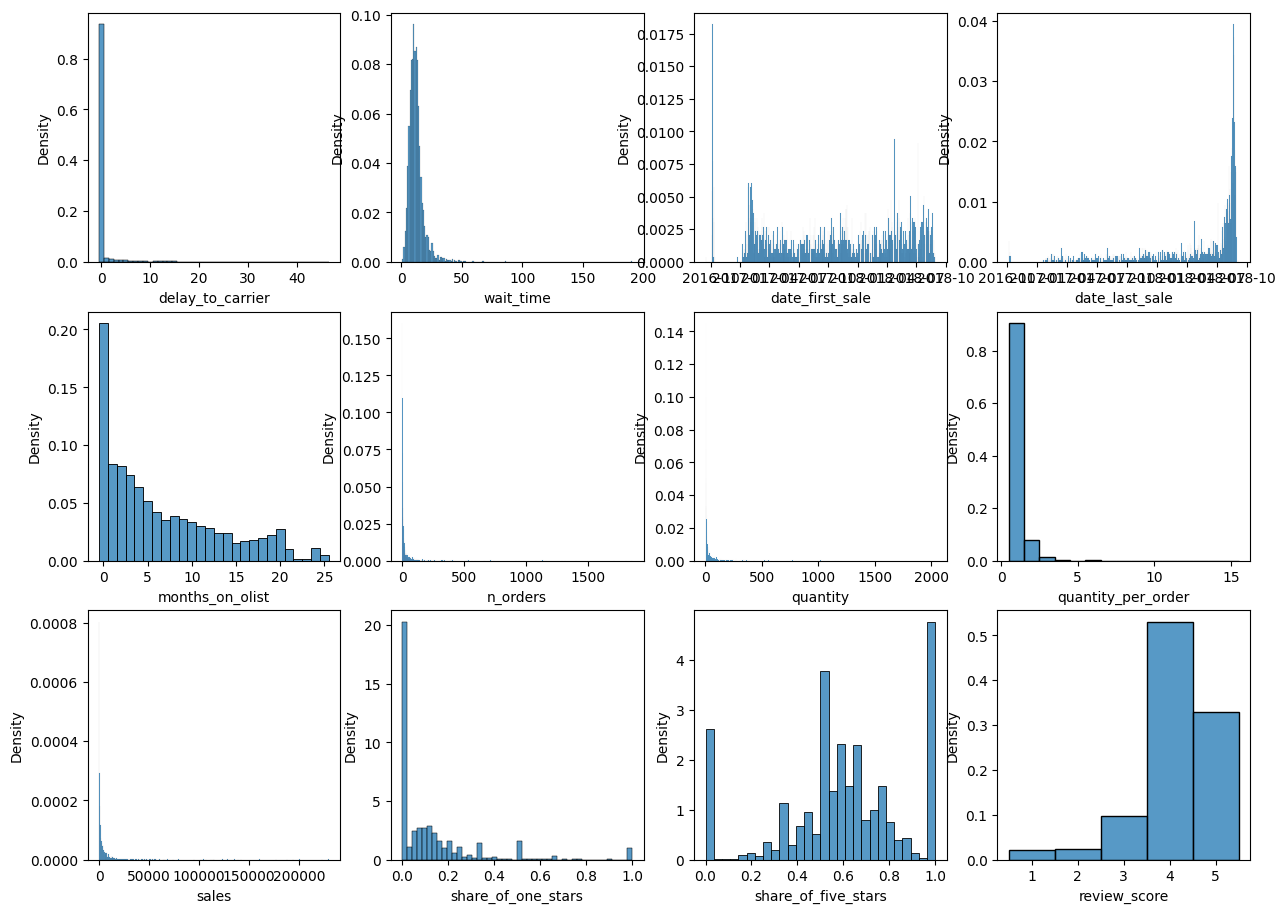

In [155]:
plt.figure(figsize=(15,11))
for (i, col) in enumerate(seller.describe().columns):#["wait_time", "delay_to_carrier", "avg_review_score", "n_orders", "quantity", "price"]):
    plt.subplot(3,4,i+1)
    sns.histplot(seller[col], kde=False, stat='density', discrete=[True,None][col in ['share_of_one_stars','share_of_five_stars','sales']]);

## Multivariate regression now with sellers
As said previously, with the orders it wasn't possible to determine a good model, so we try to recreate the same process with the sellers to see if this works

In [156]:
def standardize(df, features):
    df_standardized = df.copy()
    for f in features:
        mu = df[f].mean()
        sigma = df[f].std()
        df_standardized[f] = df[f].map(lambda x: (x - mu) / sigma)
    return df_standardized

In [157]:
features = ['delay_to_carrier', 'wait_time', 'n_orders', 'quantity', 'quantity_per_order', 'sales']
sellers_standardized = standardize(seller, features)
model = smf.ols(formula=f"review_score ~ {'+ '.join(features)}", data=sellers_standardized).fit()

Coefficients:

<Axes: >

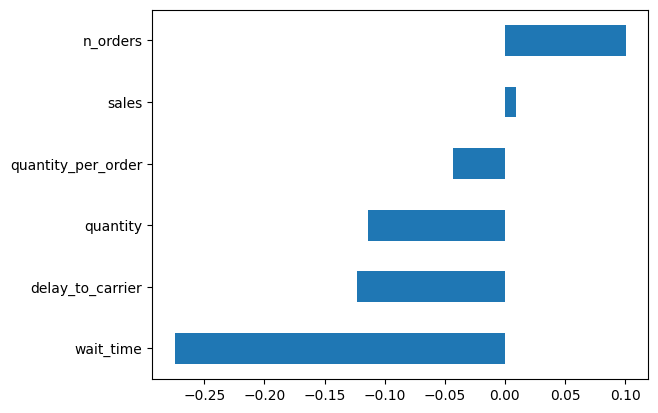

In [158]:
model.params[1:].sort_values().plot(kind='barh')

We investigate the models performance with the R squared and residuals

In [159]:
model.rsquared

np.float64(0.19430209074601978)

<Axes: xlabel='review_score', ylabel='Density'>

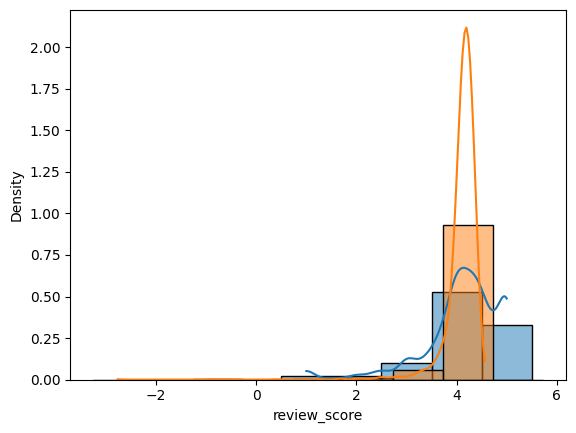

In [160]:
sns.histplot(seller.review_score, kde=True, stat='density', discrete=True)
sns.histplot(model.predict(sellers_standardized[features]), kde=True, stat='density', discrete=True)

<Axes: ylabel='Density'>

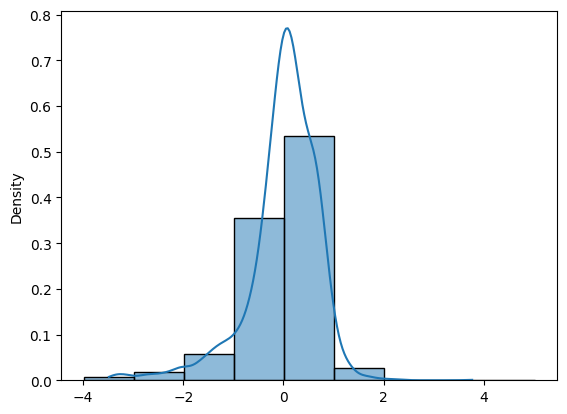

In [161]:
sns.histplot(model.resid, kde=True, stat='density', discrete=True)

We now try to add the seller state as well to our analysis, as before we werent using this feature

In [162]:
formula = 'review_score ~ C(seller_state)'
model2 = smf.ols(formula=formula, data=seller).fit()
model2.rsquared

np.float64(0.00695712131292725)

<Axes: ylabel='Density'>

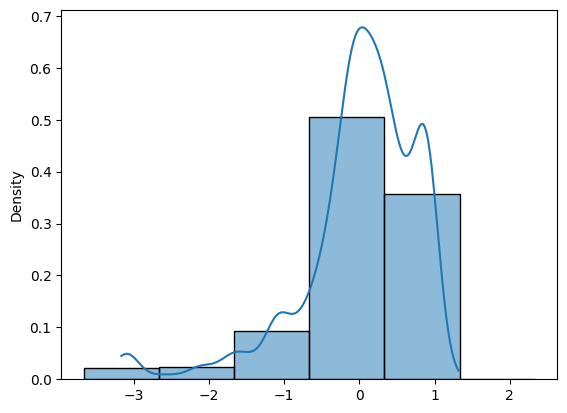

In [163]:
sns.histplot(model2.resid, kde=True, stat='density', discrete=True)

In [164]:
formula = 'review_score ~ wait_time + C(seller_state)'
model3 = smf.ols(formula=formula, data=seller).fit()


In [165]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     29.28
Date:                Wed, 25 Sep 2024   Prob (F-statistic):          1.52e-109
Time:                        17:27:14   Log-Likelihood:                -3259.5
No. Observations:                2967   AIC:                             6565.
Df Residuals:                    2944   BIC:                             6703.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.6120      0.734      6.280      0.000       3.172       6.052
C(seller_state)[T.BA]     0.2425      0.751      0.323      0.747      -1.230       1.715
C(seller_state)[T.CE]     0.0006      0.760      0.001      0.999      -1.490       1.492
C(seller_state)[T.DF]     0.0465      0.744      0.062      0.950      -1.412       1.505
C(seller_state)[T.ES]     0.3915      0.748      0.523      0.601      -1.076       1.858
C(seller_state)[T.GO]     0.2174      0.741      0.294      0.769      -1.235       1.670
C(seller_state)[T.MA]     0.2251      1.032      0.218      0.827      -1.799       2.249
C(seller_state)[T.MG]     0.1390      0.733      0.190      0.850      -1.299       1.577
C(seller_state)[T.MS]     0.2176      0.801      0.272      0.786      -1.354       1.789
C(seller_state)[T.MT]     0.2926      0.817      0.358      0.720      -1.310       1.895
C(seller_state)[T.PA]     0.5275      1.033      0.511      0.609      -1.497       2.552
C(seller_state)[T.PB]     0.2406      0.790      0.305      0.761      -1.308       1.790
C(seller_state)[T.PE]     0.1604      0.771      0.208      0.835      -1.351       1.672
C(seller_state)[T.PI]     0.1281      1.033      0.124      0.901      -1.897       2.153
C(seller_state)[T.PR]     0.1195      0.733      0.163      0.871      -1.318       1.557
C(seller_state)[T.RJ]     0.0454      0.734      0.062      0.951      -1.394       1.485
C(seller_state)[T.RN]     0.4376      0.801      0.546      0.585      -1.133       2.009
C(seller_state)[T.RO]     0.0561      0.894      0.063      0.950      -1.698       1.810
C(seller_state)[T.RS]     0.1776      0.735      0.242      0.809      -1.263       1.618
C(seller_state)[T.SC]     0.1682      0.734      0.229      0.819      -1.271       1.607
C(seller_state)[T.SE]    -0.1570      0.895     -0.175      0.861      -1.912       1.598
C(seller_state)[T.SP]     0.0209      0.732      0.028      0.977      -1.415       1.457
wait_time                -0.0476      0.002    -24.885      0.000      -0.051      -0.044
==============================================================================
Omnibus:                      867.770   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3673.250
Skew:                          -1.365   Prob(JB):                         0.00
Kurtosis:                       7.718   Cond. No.                     3.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

 After adding wait_time to our analysis, none of the 22 dummy variables is_seller_state_xx are statistically signigicant:

Given our small dataset (most states have a very limited number of sellers):
- We cannot conclude that "some states are inherently better than other for reasons that would be independent of the wait_time" 
- In other words, we cannot reject the hypothesis that "seller_state has no impact on review_score, other than through wait_time"

## Logistic regression
Now we are going to apply a logistic regression to see if the impact of wait_time and delay_vs_expected vary on good/bad reviews

In [166]:
import statsmodels.api as sm


In [167]:
selected_features = ["wait_time",
            "delay_vs_expected",
            "number_of_sellers",
            "distance_seller_customer",
            "price",
            "freight_value"]

In [168]:
# Standardizing

orders_standardized = order.copy()

for f in selected_features:
    mu = order[f].mean()
    sigma = order[f].std()
    orders_standardized[f] = order[f].map(lambda x: (x - mu) / sigma)

orders_standardized

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,number_of_products,number_of_sellers,price,freight_value,dim_is_five_star,dim_is_one_star,review_score,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,-0.431227,15.544063,-0.161799,delivered,1,-0.112541,-0.513807,-0.652039,0,0,4,-0.979465
1,53cdb2fc8bc7dce0b6741e2150273451,0.134116,19.137766,-0.161799,delivered,1,-0.112541,-0.086634,0.000484,0,0,4,0.429779
2,47770eb9100c2d0c44946d9cf07ec65d,-0.329946,26.639711,-0.161799,delivered,1,-0.112541,0.111760,-0.164041,1,0,5,-0.145470
3,949d5b44dbf5de918fe9c16f97b45f8a,0.073485,26.188819,-0.161799,delivered,1,-0.112541,-0.441528,0.206837,1,0,5,2.054689
4,ad21c59c0840e6cb83a9ceb5573f8159,-1.019545,12.112049,-0.161799,delivered,1,-0.112541,-0.562395,-0.652039,1,0,5,-0.959106
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97967,9c5dedf39a927c1b2549525ed64a053c,-0.454342,18.587442,-0.161799,delivered,1,-0.112541,-0.311513,-0.449404,1,0,5,-0.893022
97968,63943bddc261676b46f01ca7ac2f7bd8,1.023747,23.459051,-0.161799,delivered,1,-0.112541,0.183991,-0.123142,0,0,4,-0.212772
97969,83c1379a015df1e13d02aae0204711ab,1.305675,30.384225,-0.161799,delivered,1,-0.112541,0.333701,1.964559,1,0,5,0.617670
97970,11c177c8e97725db2631073c19f07b62,0.483593,37.105243,-0.161799,delivered,2,-0.112541,1.075223,2.715610,0,0,2,-0.387537


Check the `multi-colinearity` of features, using the `VIF index`.

* It shouldn't be too high (< 10 preferably) to ensure that we can trust the partial regression coefficents and their associated `p-values` 

In [169]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

X_standardized = orders_standardized[selected_features]
df = pd.DataFrame()
df["features"] = X_standardized.columns
df["vif_index"] = [vif(X_standardized.values, i) for i in range(X_standardized.shape[1])]
round(df,2)

,features,vif_index
0,wait_time,2.62
1,delay_vs_expected,2.21
2,number_of_sellers,1.02
3,distance_seller_customer,1.41
4,price,1.21
5,freight_value,1.36


We fit two `Logistic Regression` models:
- `logit_one` to predict `dim_is_one_star` 
- `logit_five` to predict `dim_is_five_star`.

In [170]:
logit_one = smf.logit(formula='dim_is_one_star ~'+ ' + '.join(selected_features), data=orders_standardized).fit()
print(logit_one.summary())

Optimization terminated successfully.
         Current function value: 0.276542
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        dim_is_one_star   No. Observations:                95878
Model:                          Logit   Df Residuals:                    95871
Method:                           MLE   Df Model:                            6
Date:                Wed, 25 Sep 2024   Pseudo R-squ.:                  0.1357
Time:                        17:27:15   Log-Likelihood:                -26514.
converged:                       True   LL-Null:                       -30678.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.4468      0.013   -191.766      0.000      -2.472

In [171]:
logit_five = smf.logit(formula='dim_is_five_star ~'+ ' + '.join(selected_features), data=orders_standardized).fit()
print(logit_five.summary())

Optimization terminated successfully.
         Current function value: 0.638277
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:       dim_is_five_star   No. Observations:                95878
Model:                          Logit   Df Residuals:                    95871
Method:                           MLE   Df Model:                            6
Date:                Wed, 25 Sep 2024   Pseudo R-squ.:                 0.05593
Time:                        17:27:15   Log-Likelihood:                -61197.
converged:                       True   LL-Null:                       -64822.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.3382      0.007     47.322      0.000       0.324

delay_vs_expected influences five_star ratings even more than one_star ratings, and wait_time influences one_star ratings even more than five_star ratings

## Key Findings, so far
- `wait_time` is the most significant factor behind low review scores  
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`.  
- The latter being outside of Olist's direct control, improving it is not a quick-win recommendation
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.
- Comments of the bad reviews showed that some were linked to the seller or to the product itself.

# Now we are going to examine the products
We do this to see if removing some products could yield benefits

In [172]:
def get_product_features(products = products, en_category = product_category):
    """
    Returns a DataFrame with:
    'product_id', 'product_category_name', 'product_name_length',
    'product_description_length', 'product_photos_qty', 'product_weight_g',
    'product_length_cm', 'product_height_cm', 'product_width_cm'
    """
    df = products.merge(en_category, on='product_category_name')
    df.drop(['product_category_name'], axis=1, inplace=True)
    df.rename(columns={
        'product_category_name_english': 'category',
        'product_name_lenght': 'product_name_length',
        'product_description_lenght': 'product_description_length'
    },
                inplace=True)

    return df
get_product_features().head()

,product_id,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares


In [173]:
def get_price(order_items = order_items):
    """
    Return a DataFrame with:
    'product_id', 'price'
    """
    # There are many different order_items per product_id, each with different prices. Take the mean of the various prices
    return order_items[['product_id',
                        'price']].groupby('product_id').mean().reset_index()
get_price().head()

,product_id,price
0,00066f42aeeb9f3007548bb9d3f33c38,101.65
1,00088930e925c41fd95ebfe695fd2655,129.90
2,0009406fd7479715e4bef61dd91f2462,229.00
3,000b8f95fcb9e0096488278317764d19,58.90
4,000d9be29b5207b54e86aa1b1ac54872,199.00


In [174]:
def get_product_wait_time(order_items = order_items):
    """
    Returns a DataFrame with:
    'product_id', 'wait_time'
    """
    orders_wait_time = get_wait_time()
    orders_products = order_items[['order_id', 'product_id']].drop_duplicates()
    orders_products_with_time = orders_products.merge(orders_wait_time, on='order_id')

    return orders_products_with_time.groupby('product_id',
                        as_index=False).agg({'wait_time': 'mean'})

In [175]:
def get_quantity(order_items = order_items):
    """
    Returns a DataFrame with:
    'product_id', 'n_orders', 'quantity'
    """
    n_orders =\
        order_items.groupby('product_id')['order_id'].nunique().reset_index()
    n_orders.columns = ['product_id', 'n_orders']

    quantity = \
        order_items.groupby('product_id',
                                as_index=False).agg({'order_id': 'count'})
    quantity.columns = ['product_id', 'quantity']

    return n_orders.merge(quantity, on='product_id')
get_quantity().head()

,product_id,n_orders,quantity
0,00066f42aeeb9f3007548bb9d3f33c38,1,1
1,00088930e925c41fd95ebfe695fd2655,1,1
2,0009406fd7479715e4bef61dd91f2462,1,1
3,000b8f95fcb9e0096488278317764d19,2,2
4,000d9be29b5207b54e86aa1b1ac54872,1,1


In [176]:
def get_sales(order_items = order_items):
    """
    Returns a DataFrame with:
    'product_id', 'sales'
    """
    return order_items[['product_id', 'price']]\
        .groupby('product_id')\
        .sum()\
        .rename(columns={'price': 'sales'}).reset_index()
get_sales().head()

,product_id,sales
0,00066f42aeeb9f3007548bb9d3f33c38,101.65
1,00088930e925c41fd95ebfe695fd2655,129.90
2,0009406fd7479715e4bef61dd91f2462,229.00
3,000b8f95fcb9e0096488278317764d19,117.80
4,000d9be29b5207b54e86aa1b1ac54872,199.00


In [177]:
def get_product_review_score(order_items = order_items):
    """
    Returns a DataFrame with:
    'product_id', 'share_of_five_stars', 'share_of_one_stars',
    'review_score'
    """
    orders_reviews = get_review_score()
    orders_products = order_items[['order_id',
                                        'product_id']].drop_duplicates()
    df = orders_products.merge(orders_reviews, on='order_id')

    df['cost_of_reviews'] = df.review_score.map({
        1: 100,
        2: 50,
        3: 40,
        4: 0,
        5: 0
    })

    df = df.groupby('product_id', as_index=False).agg({
        'dim_is_one_star':
        'mean',
        'dim_is_five_star':
        'mean',
        'review_score':
        'mean',
        'cost_of_reviews':
        'sum'
    })
    df.columns = [
        'product_id', 'share_of_one_stars', 'share_of_five_stars',
        'review_score', 'cost_of_reviews'
    ]

    return df
get_product_review_score().head()

,product_id,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews
0,00066f42aeeb9f3007548bb9d3f33c38,0.0,1.0,5.0,0
1,00088930e925c41fd95ebfe695fd2655,0.0,0.0,4.0,0
2,0009406fd7479715e4bef61dd91f2462,1.0,0.0,1.0,100
3,000b8f95fcb9e0096488278317764d19,0.0,1.0,5.0,0
4,000d9be29b5207b54e86aa1b1ac54872,0.0,1.0,5.0,0


In [178]:
def get_product_training_data():
    
    training_set =\
        get_product_features()\
            .merge(
            get_product_wait_time(), on='product_id'
            ).merge(
            get_price(), on='product_id'
            ).merge(
            get_product_review_score(), on='product_id'
            ).merge(
            get_quantity(), on='product_id'
            ).merge(
            get_sales(), on='product_id'
            )

    # compute the economics (revenues, profits)
    olist_sales_cut = 0.1
    training_set['revenues'] = olist_sales_cut * training_set['sales']
    training_set['profits'] = training_set['revenues'] - training_set[
        'cost_of_reviews']
    return training_set

def get_product_cat():
    training_set = get_product_training_data()
    columns = list(training_set.select_dtypes(exclude=['object']).columns)
    agg_params = dict(zip(columns, ["mean"] * len(columns)))
    agg_params['quantity'] = 'sum'

    product_cat = training_set.groupby("category").agg(agg_params)
    return product_cat

get_product_training_data().head()

,product_id,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category,wait_time,price,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,sales,revenues,profits
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,3.017639,10.91,0.0,1.0,5.0,0,1,1,10.91,1.091,1.091
1,3aa071139cb16b67ca9e5dea641aaa2f,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art,15.771898,248.00,0.0,1.0,5.0,0,1,1,248.00,24.800,24.800
2,96bd76ec8810374ed1b65e291975717f,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure,2.087674,79.80,0.0,1.0,5.0,0,1,1,79.80,7.980,7.980
3,cef67bcfe19066a932b7673e239eb23d,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby,3.262986,112.30,1.0,0.0,1.0,100,1,1,112.30,11.230,-88.770
4,9dc1a7de274444849c219cff195d0b71,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares,2.899387,37.90,0.0,1.0,5.0,0,1,1,37.90,3.790,3.790


In [179]:
product = get_product_training_data()

In [180]:
prod_cat = get_product_cat()
prod_cat = prod_cat.sort_values('sales',ascending=False)

In [181]:
prod_cat.head()

,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,wait_time,price,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,sales,revenues,profits
category,,,,,,,,,,,,,,,,,,
computers,55.724138,2135.517241,2.655172,8075.862069,31.379310,34.896552,39.862069,12.874778,1183.207284,0.109475,0.542101,4.143928,89.655172,6.206897,202,7456.349310,745.634931,655.979759
small_appliances_home_oven_and_coffee,52.903226,1046.387097,2.387097,3071.516129,31.322581,22.838710,23.870968,8.555922,398.382196,0.113833,0.607709,4.228858,29.354839,2.451613,76,1530.506774,153.050677,123.695839
home_appliances_2,48.377778,797.633333,2.333333,9913.333333,45.733333,30.666667,38.166667,14.449557,508.155697,0.113183,0.513931,3.970494,35.888889,2.600000,238,1259.086000,125.908600,90.019711
agro_industry_and_commerce,49.108108,807.756757,2.310811,5263.405405,36.527027,28.945946,25.810811,11.602829,438.692969,0.151821,0.436733,3.805768,39.459459,2.472973,212,980.141486,98.014149,58.554689
watches_gifts,49.796366,613.040878,2.230129,510.367903,19.224830,10.314156,15.267222,12.360014,336.710866,0.106442,0.617209,4.171768,75.715367,4.383800,5983,910.963172,91.096317,15.380950


C:\Users\migue\AppData\Local\Temp\ipykernel_13404\454757158.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=prod_cat, y='category', x='sales', palette=colors)
C:\Users\migue\AppData\Local\Temp\ipykernel_13404\454757158.py:6: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(data=prod_cat, y='category', x='sales', palette=colors)


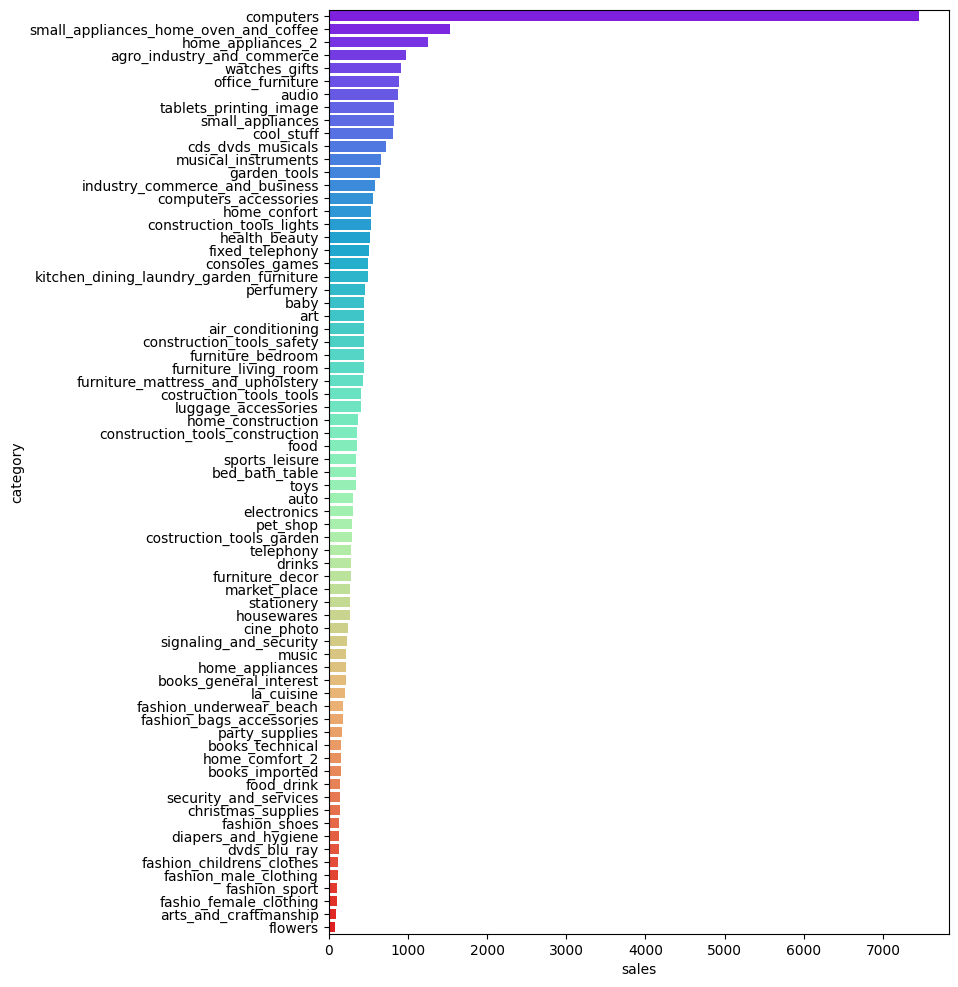

In [182]:
import matplotlib.cm as cm

norm = np.linspace(0, 1, prod_cat.shape[0])
colors = cm.rainbow(norm)

ax = sns.barplot(data=prod_cat, y='category', x='sales', palette=colors)
ax.figure.set_size_inches(8, 12)

C:\Users\migue\AppData\Local\Temp\ipykernel_13404\478774894.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=prod_cat.sort_values('profits',ascending=False), y='category', x='profits', palette=colors)
C:\Users\migue\AppData\Local\Temp\ipykernel_13404\478774894.py:1: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(data=prod_cat.sort_values('profits',ascending=False), y='category', x='profits', palette=colors)


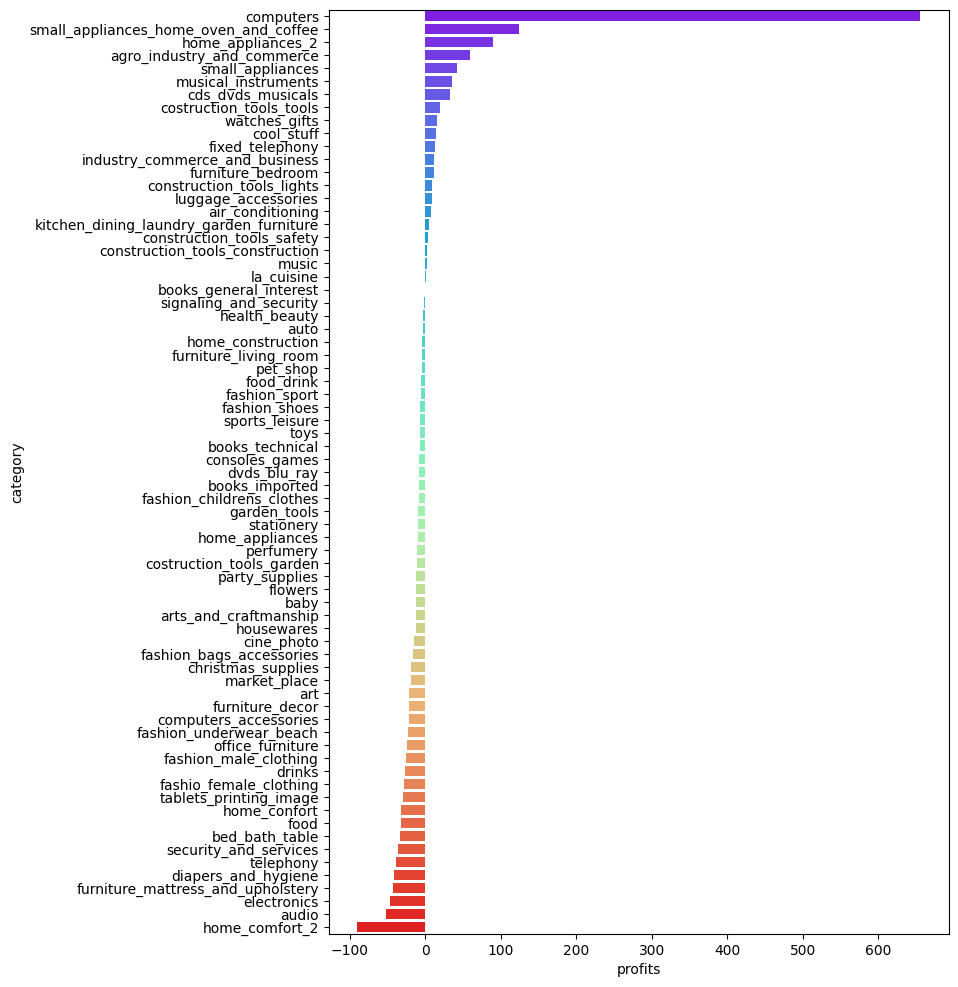

In [183]:
ax = sns.barplot(data=prod_cat.sort_values('profits',ascending=False), y='category', x='profits', palette=colors)
ax.figure.set_size_inches(8, 12)

From what we can see some of the products present losses to the company, thus it may be a good idea remove some products and focus on others. A good idea might be instead of trying to cover every possible object in the market and be a one stop shop for everything, like amazon does, maybe it is better to start focusing on only one category of products and become really good and profitable with that one, and after having several months with profits start adding new products again

Even though items arent as costly as the number of sellers if an item is producing a really negative income is not worth having it in the store, and so every item that appears in red would be subject of removal


# Advance analysis
We have analyzed practically everything by now. But now we are going to see if removing under performing sellers will yield benefits or not, because added sellers cost the company IT_cost

In [184]:
seller_cost = order_items[["order_id", "seller_id", "price"]].merge(reviews[["order_id", "review_score"]], on="order_id")

In [185]:
# i want review score to be {1: 100,2: 50,3: 40,4: 0,5: 0}
seller_cost["cost_of_review"] = seller_cost["review_score"].map({1: -100,2: -50,3: -40,4: 0,5: 0})
seller_cost.head()

,order_id,seller_id,price,review_score,cost_of_review
0,00010242fe8c5a6d1ba2dd792cb16214,48436dade18ac8b2bce089ec2a041202,58.90,5,0
1,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,239.90,4,0
2,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,199.00,5,0
3,00024acbcdf0a6daa1e931b038114c75,9d7a1d34a5052409006425275ba1c2b4,12.99,4,0
4,00042b26cf59d7ce69dfabb4e55b4fd9,df560393f3a51e74553ab94004ba5c87,199.90,5,0


In [186]:
# i want seller_cost group by seller_id and sum the price and cost_of_review
seller_cost = seller_cost.groupby("seller_id").agg({"price": "sum", "cost_of_review": "sum"}).reset_index()
# order seller_cost by cost_of_review in descending order
seller_cost['revenues'] = 0.1 * seller_cost['price']
seller_cost["profit"] = seller_cost["revenues"] + seller_cost["cost_of_review"]
seller_cost = seller_cost.sort_values("profit", ascending=True)

seller_cost.head()

,seller_id,price,cost_of_review,revenues,profit
1232,6560211a19b47992c3666cc44a7e94c0,122484.82,-40120,12248.482,-27871.518
368,1f50f920176fa81dab994f9023523100,107002.21,-37490,10700.221,-26789.779
1532,7c67e1448b00f6e969d365cea6b010ab,188017.85,-44290,18801.785,-25488.215
878,4a3ca9315b744ce9f8e9374361493884,200561.42,-44620,20056.142,-24563.858
2476,cc419e0650a3c5ba77189a1882b7556a,106059.06,-31070,10605.906,-20464.094


In [187]:
# add months_on_olist from seller to seller_cost
seller_cost = seller_cost.merge(seller[["seller_id", "months_on_olist"]], on="seller_id")
seller_cost.head()

,seller_id,price,cost_of_review,revenues,profit,months_on_olist
0,6560211a19b47992c3666cc44a7e94c0,122484.82,-40120,12248.482,-27871.518,20.0
1,1f50f920176fa81dab994f9023523100,107002.21,-37490,10700.221,-26789.779,18.0
2,7c67e1448b00f6e969d365cea6b010ab,188017.85,-44290,18801.785,-25488.215,20.0
3,4a3ca9315b744ce9f8e9374361493884,200561.42,-44620,20056.142,-24563.858,21.0
4,cc419e0650a3c5ba77189a1882b7556a,106059.06,-31070,10605.906,-20464.094,20.0


In [188]:
items_cost = 978.23*(product.shape[0])**(0.5)

In [189]:
n_sellers_profit = pd.DataFrame({
    'n_sellers': [],
    'profit': []
})

for i in range(seller_cost.shape[0]):
    current_sellers = seller_cost.iloc[i:,:]
    n_sellers = current_sellers.shape[0]
    sellers_profit = current_sellers["profit"].sum() + 80*current_sellers["months_on_olist"].sum()
    it_cost = 3157.27*(n_sellers)**(0.5) + items_cost
    profit = sellers_profit-it_cost
    n_sellers_profit.loc[i] = [n_sellers, profit]

Text(0.5, 1.0, 'Profit vs. Number of Sellers')

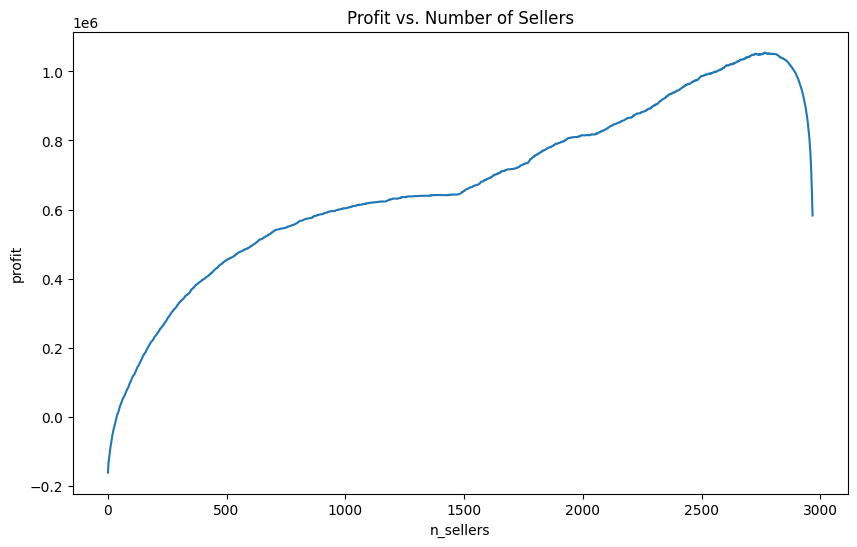

In [190]:
# do a lineplot of profit vs n_sellers
plt.figure(figsize=(10, 6))
sns.lineplot(data=n_sellers_profit, x="n_sellers", y="profit")
plt.title("Profit vs. Number of Sellers")

In [191]:
seller.shape[0]

2967

In [192]:
n_sellers_profit.loc[n_sellers_profit["profit"].idxmax()]

n_sellers    2.768000e+03
profit       1.054428e+06
Name: 199, dtype: float64

## Number of sellers to fire
Currently there are 2967 sellers and the sellers that are causing this company's profit to dip are only a few, so the recomendation is to fire the worse sellers untill Olist is left with 2768 sellers.

With the firing of some sellers, and removal of some products we would have the maximum profit possible